In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from scipy import integrate
from IPython.display import clear_output

In [17]:
def Runge(Ih, I2h, p):
    return abs(I2h - Ih)/(2**p-1)

def epsilon():
    e = 1;
    while 1 + e > 1:
        e = e/2;

    return e

In [18]:
def _Simpson(a, b, f, h):
    X = np.arange(a, b, h)
    Y = [f(x) for x in X]

    S1 = 0
    S2 = 0
    for x in X:
        S1 += f(x+h/2)
    
    for x in X[1:]:
        S2 += f(x)
        
    return h/6*(f(a) + 4*S1 + 2*S2 + f(b))
    
def Simpson(a, b, f, epsabs):
    h = (b-a)/2
    S = _Simpson(a, b, f, h)
    S2 = 0
#     print(h, epsabs, Runge(S2, S, 4))
    while Runge(S2, S, 4) >= epsabs:
        S2 = S
        h /= 2
        S = _Simpson(a, b, f, h)
#         print(h, epsabs, Runge(S2, S, 4))
        
    return S
    
    
    

In [25]:
def finite_element_method(a, b, ua, ub, k, q, f, internal_points_count, mode, epsabs = 1.0e-10):
    N = internal_points_count+1
    print(a, b, N)
    h = (b-a)/N
    X = [a + h*i for i in range(N+1)]
    def phi(_n, _x):
        if  _n == 0:
            return np.where((a <= _x) & (_x <= X[1]), (X[1] - _x)/h, 0)
        else:
            if _n == N:
                return np.where((X[N-1] <= _x) & (_x <= b),  (_x - X[N-1])/h, 0)
            else:
                return np.where((X[_n-1] <= _x) & (_x <=X[_n]), (_x - X[_n-1])/h, np.where((X[_n] <= _x) & (_x<= X[_n+1]), (X[_n+1] - _x)/h, 0))
    
    def f1(x, t1):
        return f(x)*(x-t1)/h
    def f2(x, t2):
        return f(x)*(t2-x)/h
    def f3(x, t1, t2):
        return q(x)*(x-t1)/h*(t2-x)/h
    def f4(x, t1):
        return q(x)*((x-t1)/h)*((x-t1)/h)
    def f5(x, t2):
        return q(x)*((t2-x)/h)**2
    
    integrate.quad
    
    if mode == "simpson":
        simpson = partial(Simpson, epsabs = epsabs)
#         simpson = partial(_Simpson, h = h)
        def bi(xi):
            return simpson(xi-h, xi, partial(f1, t1 = xi-h)) + simpson(xi, xi+h, partial(f2, t2 = xi+h))
    
        def a1(xi):
            return -k/h + simpson(xi-h, xi, partial(f3, t1 = xi-h, t2 = xi))

        def a2(xi):
            return 2*k/h + simpson(xi-h, xi, partial(f4, t1 = xi-h)) + simpson(xi, xi+h, partial(f5, t2 = xi+h))

        def a3(xi):
            return -k/h + simpson(xi, xi+h, partial(f3, t1 = xi, t2 = xi+h))
    if mode == "quad":
        def bi(xi):
            return integrate.quad(partial(f1, t1 = xi-h), xi-h, xi, epsabs = epsabs)[0] + integrate.quad(partial(f2, t2 = xi+h), xi, xi+h, epsabs = epsabs)[0]
    
        def a1(xi):
            return -k/h + integrate.quad(partial(f3, t1 = xi-h, t2 = xi), xi-h, xi, epsabs = epsabs)[0]

        def a2(xi):
            return 2*k/h + integrate.quad(partial(f4, t1 = xi-h), xi-h, xi, epsabs = epsabs)[0] + integrate.quad(partial(f5, t2 = xi+h), xi, xi+h, epsabs = epsabs)[0]

        def a3(xi):
            return -k/h + integrate.quad(partial(f3, t1 = xi, t2 = xi+h), xi, xi+h, epsabs = epsabs)[0]
    
    A = np.zeros((internal_points_count+2, internal_points_count+2))
    B = np.zeros(internal_points_count+2)
    
    A[0, 0] = 1
    A[N, N] = 1
    B[0] = ua
    B[N] = ub

    xi = a+h
    for i in range(1, N):
        A[i, i-1] = a1(xi)
        A[i, i] = a2(xi)
        A[i, i+1] = a3(xi)
        B[i] = bi(xi)
        xi += h
        
    Alpha = np.linalg.solve(A, B)
    
    def res(coefficients, x):
        r = 0
        for i in range(N+1):
            r += phi(i, x)*coefficients[i]
        return r

    return partial(res, Alpha)



In [27]:
a = 0
b = 1
k = 2
internal_points_count = 150
ua = 2
ub = 4

def q(x):
    return np.cos(x)

def f(x):
    return -2*(6*x+2) + np.cos(x)*(x**3 + x**2 + 2)

def u(x):
    return x**3 + x**2 + 2

0 1 11


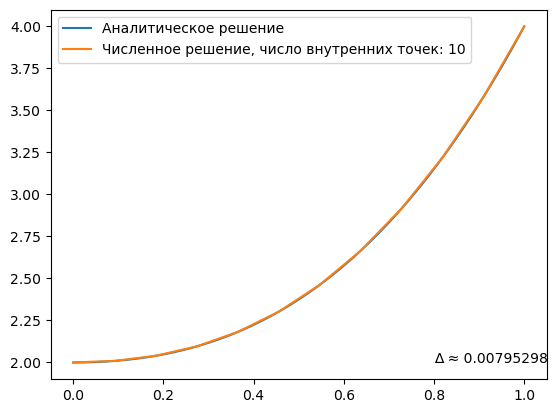

In [28]:
internal_points_count = 10
Y = []

v = finite_element_method(a, b, ua, ub, 2, q, f, internal_points_count, 'simpson', 0.1)
X = np.linspace(a, b, 1000, endpoint=True)
plt.plot(X, u(X), label = f"Аналитическое решение")
plt.plot(X, v(X), label = f"Численное решение, число внутренних точек: {internal_points_count}")
plt.text(0.8, 2, f"∆ ≈ {max(np.abs(u(X) - v(X))):.8f}")
plt.legend()
plt.show()
Y.append(max(np.abs(u(X) - v(X))))

In [174]:
def finite_element_method_analytically(a, b, ua, ub, k, internal_points_count):
    N = internal_points_count+1
    h = (b-a)/N
    X = [a + h*i for i in range(N+1)]
    def phi(_n, _x):
        if  _n == 0:
            return np.where((a <= _x) & (_x <= X[1]), (X[1] - _x)/h, 0)
        else:
            if _n == N:
                return np.where((X[N-1] <= _x) & (_x <= b),  (_x - X[N-1])/h, 0)
            else:
                return np.where((X[_n-1] <= _x) & (_x <=X[_n]), (_x - X[_n-1])/h, np.where((X[_n] <= _x) & (_x<= X[_n+1]), (X[_n+1] - _x)/h, 0))

                        
#     def a1():
#         return -2/h+h/6
    
#     def a2():
#         return 4/h+2*h/3
    
#     def a3():
#         return a1()
    
    def a1(xi):
        return -k/h + -(2*np.sin(xi-h)+h*np.cos(xi-h)-2*np.sin(xi)+h*np.cos(xi))/h**2
    
    def a2(xi):
        res = 2*k/h
        res += (2*np.sin(xi-h)+(h**2-2)*np.sin(xi)+2*h*np.cos(xi))/h**2
        res += (-2*np.sin(xi+h)-(h**2-2)*np.sin(xi)+2*h*np.cos(xi))/h**2
        return res
  
    def a3(xi):
        return -k/h + (2*np.sin(xi+h)-h*np.cos(xi+h)-2*np.sin(xi)-h*np.cos(xi))/h**2

    def int1(xi):
        return ((6*xi**2+(4-12*h)*xi+6*h**2-4*h-24)*np.sin(xi-h)+(-xi**3+(3*h-1)*xi**2+(-3*h**2+2*h+18)*xi+h**3-h**2-18*h+4)*np.cos(xi-h)+(h*xi**3+(h-6)*xi**2+(-6*h-4)*xi+24)*np.sin(xi)+(xi**3+(3*h+1)*xi**2+(2*h-18)*xi-6*h-4)*np.cos(xi)-6*h**2*xi+2*h**3-2*h**2)/h
    def int2(xi):
        return ((6*xi**2+(12*h+4)*xi+6*h**2+4*h-24)*np.sin(xi+h)+(-xi**3+(-3*h-1)*xi**2+(-3*h**2-2*h+18)*xi-h**3-h**2+18*h+4)*np.cos(xi+h)+(-h*xi**3+(-h-6)*xi**2+(6*h-4)*xi+24)*np.sin(xi)+(xi**3+(1-3*h)*xi**2+(-2*h-18)*xi+6*h-4)*np.cos(xi)-6*h**2*xi-2*h**3-2*h**2)/h#     def int1(x1, xi, x2):
#        return 1/60/h*(12*xi**5 + (15 - 15*x1)*xi**4 + (-20*x1 - 240)*xi**3 + (360*x1-60)*xi**2+120*x1*xi+3*x1**5+5*x1**4-120*x1**3-60*x1**2)
    
#     def int2(x1, xi, x2):
#        return 1/60/h*(3*x2**5 + 5*x2**4-120*x2**3-60*x2**2 + (-15*xi**4 - 20*xi**3 + 360*xi**2 + 120*xi)*x2 + 12*xi**5 + 15*xi**4-240*xi**3-60*xi**2)
    
    
    def bi(xi):
        return int1(xi) + int2(xi)
    
    
    A = np.zeros((internal_points_count+2, internal_points_count+2))
    B = np.zeros(internal_points_count+2)
    
    A[0, 0] = 1
    A[N, N] = 1
    B[0] = ua
    B[N] = ub
    xi = a+h
    for i in range(1, N):
        A[i, i-1] = a1(xi)
        A[i, i] = a2(xi)
        A[i, i+1] = a3(xi)
        B[i] = bi(xi)
        xi += h
        
    Alpha = np.linalg.solve(A, B)
    
    def res(coefficients, x):
        r = 0
        for i in range(N+1):
            r += phi(i, x)*coefficients[i]
        return r
    
    return partial(res, Alpha)
   

In [175]:
# def finite_element_method_analytically(a, b, ua, ub, internal_points_count):
#     N = internal_points_count+1
#     h = (b-a)/N
#     X = [a + h*i for i in range(N+1)]
#     def phi(_n, _x):
#         if  _n == 0:
#             return np.where((a <= _x) & (_x <= X[1]), (X[1] - _x)/h, 0)
#         else:
#             if _n == N:
#                 return np.where((X[N-1] <= _x) & (_x <= b),  (_x - X[N-1])/h, 0)
#             else:
#                 return np.where((X[_n-1] <= _x) & (_x <=X[_n]), (_x - X[_n-1])/h, np.where((X[_n] <= _x) & (_x<= X[_n+1]), (X[_n+1] - _x)/h, 0))

In [164]:
v = finite_element_method_analytically(a, b, ua, ub, 2, internal_points_count)

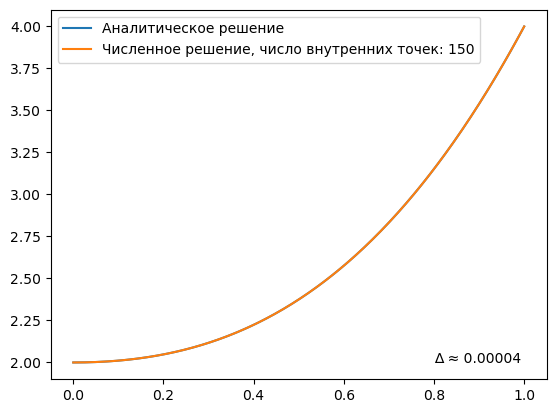

In [118]:
X = np.linspace(a, b, 1000, endpoint=True)
plt.plot(X, u(X), label = f"Аналитическое решение")
plt.plot(X, v(X), label = f"Численное решение, число внутренних точек: {internal_points_count}")
plt.text(0.8, 2, f"∆ ≈ {max(np.abs(u(X) - v(X))):.5f}")
plt.legend()
plt.show()

In [128]:
def get_abs(a, b, N, X, epsabs):
    N = 500
    T = [i for i in range(N)]
    Y = []
    Y1 = []
    Y2 = []
    for internal_points_count in range(N):
        v = finite_element_method(a, b, ua, ub, 2, q, f, internal_points_count, 'simpson', epsabs = epsabs)
        Y.append(max(np.abs(u(X) - v(X))))
        v = finite_element_method(a, b, ua, ub, 2, q, f, internal_points_count, 'quad', epsabs = epsabs)
        Y1.append(max(np.abs(u(X) - v(X))))
        v = finite_element_method_analytically(a, b, ua, ub, 2, internal_points_count)
        Y2.append(max(np.abs(u(X) - v(X))))
        if (internal_points_count+1) % 10 == 0 or internal_points_count == N-1:
            clear_output(wait = True)
            print(internal_points_count+1)
    return Y, Y1, Y2

In [129]:
N = 500
X = np.linspace(a, b, 1000, endpoint=True)
Y, Y1, Y2 = get_abs(a, b, N, X, epsabs = 1.0e-10)

500


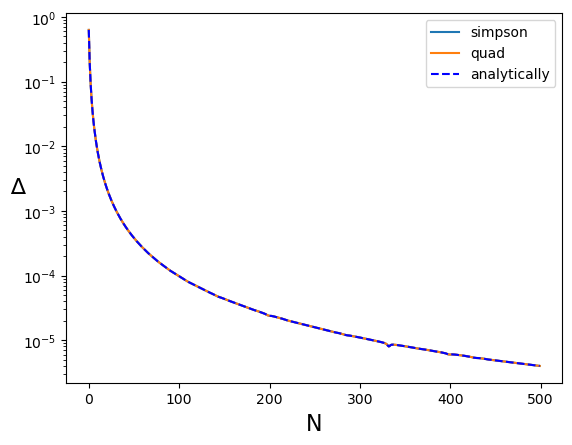

In [130]:
plt.plot(T, Y, label = f"simpson")
plt.plot(T, Y1, label = f"quad")
plt.plot(T, Y2,'b--', label = f"analytically")
plt.xlabel('N', fontsize=16)
plt.ylabel('∆', fontsize=16, rotation = 0)
plt.semilogy()
plt.legend()
plt.show()

500


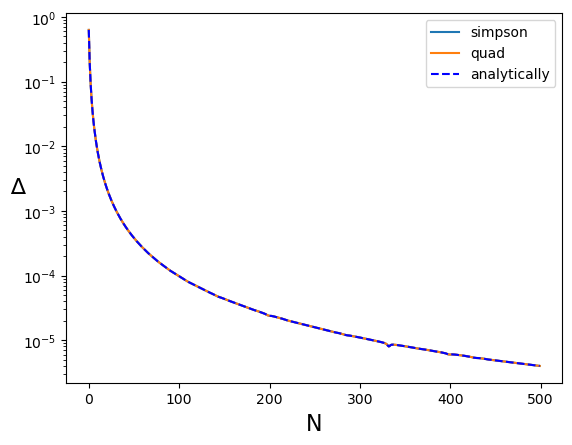

In [131]:
Y, Y1, Y2 = get_abs(a, b, N, X, epsabs = 1.0e-8)
plt.plot(T, Y, label = f"simpson")
plt.plot(T, Y1, label = f"quad")
plt.plot(T, Y2,'b--', label = f"analytically")
plt.xlabel('N', fontsize=16)
plt.ylabel('∆', fontsize=16, rotation = 0)
plt.semilogy()
plt.legend()
plt.show()

500


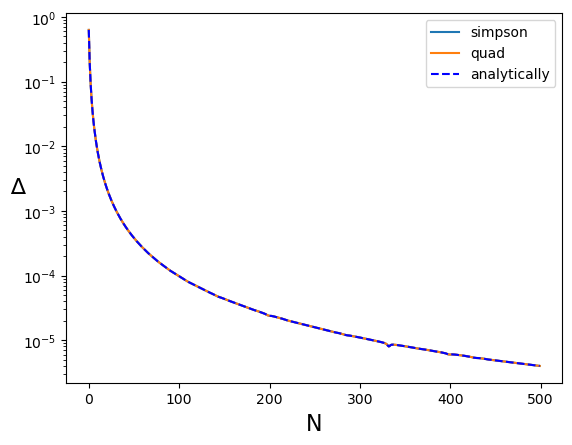

In [132]:
Y, Y1, Y2 = get_abs(a, b, N, X, epsabs = 1.0e-6)
plt.plot(T, Y, label = f"simpson")
plt.plot(T, Y1, label = f"quad")
plt.plot(T, Y2,'b--', label = f"analytically")
plt.xlabel('N', fontsize=16)
plt.ylabel('∆', fontsize=16, rotation = 0)
plt.semilogy()
plt.legend()
plt.show()

500


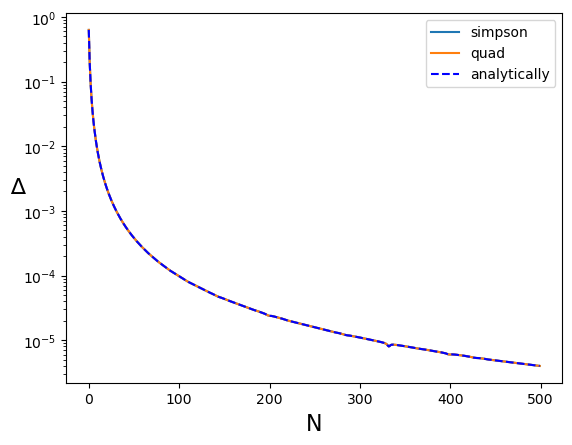

In [203]:
Y, Y1, Y2 = get_abs(a, b, N, X, epsabs = 1.0e-1)
plt.plot(T, Y, label = f"simpson")
plt.plot(T, Y1, label = f"quad")
plt.plot(T, Y2,'b--', label = f"analytically")
plt.xlabel('N', fontsize=16)
plt.ylabel('∆', fontsize=16, rotation = 0)
plt.semilogy()
plt.legend()
plt.show()

In [204]:
Y, Y1, Y2 = get_abs(a, b, N, X, epsabs = 1.0e-1)
Y_, Y1_, Y2_ = get_abs(a, b, N, X, epsabs = 1.0e-10)

500


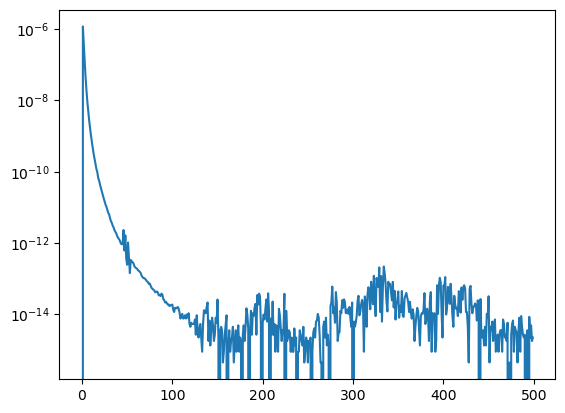

In [213]:
plt.plot(T, abs(Y - Y_))
plt.semilogy()
plt.show()

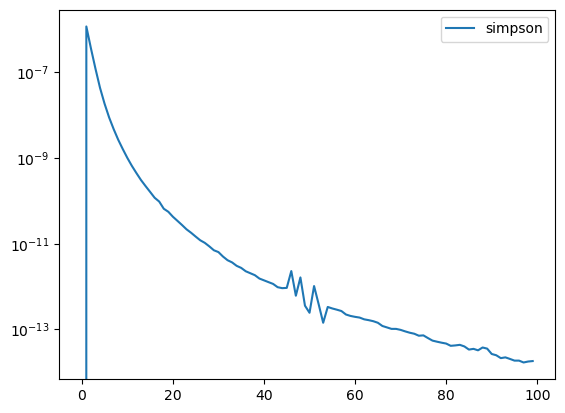

In [211]:
plt.plot(T[:100], abs(Y - Y_)[:100], label = f"simpson")
plt.semilogy()
plt.legend()
plt.show()

In [76]:
Y = []
for internal_points_count in range(N):
    v = finite_element_method(a, b, ua, ub, 2, q, f, internal_points_count, 'simpson')
    Y.append(max(np.abs(u(X) - v(X))))
    if internal_points_count % 10 == 0:
        clear_output(wait = True)
        print(internal_points_count)
Y = np.array(Y)

490


In [46]:
Y1 = []
for internal_points_count in range(N):
    v = finite_element_method(a, b, ua, ub, 2, q, f, internal_points_count, 'quad')
    Y1.append(max(np.abs(u(X) - v(X))))
    if internal_points_count % 10 == 0:
        clear_output(wait = True)
        print(internal_points_count)
Y1 = np.array(Y1)

490


In [49]:
Y2 = []
for internal_points_count in range(N):
    v = finite_element_method_analytically(a, b, ua, ub, 2, internal_points_count)
    Y2.append(max(np.abs(u(X) - v(X))))
    if internal_points_count % 10 == 0:
        clear_output(wait = True)
        print(internal_points_count)
Y2 = np.array(Y2)

490


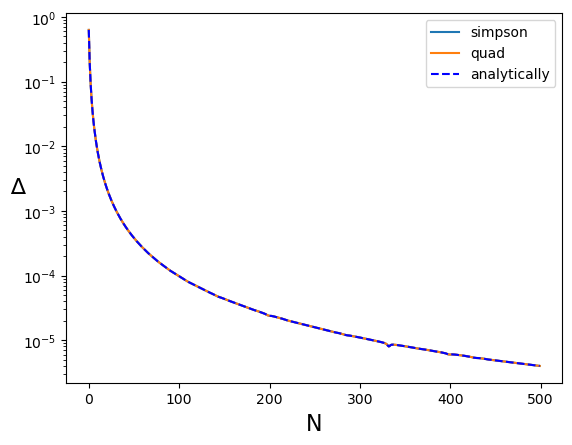

In [94]:
plt.plot(T, Y, label = f"simpson")
plt.plot(T, Y1, label = f"quad")
plt.plot(T, Y2,'b--', label = f"analytically")
plt.xlabel('N', fontsize=16)
plt.ylabel('∆', fontsize=16, rotation = 0)
plt.semilogy()
plt.legend()
plt.show()

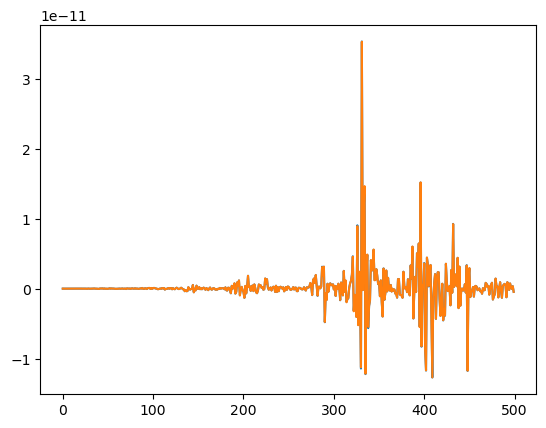

In [87]:
plt.plot(T, Y2 - Y1, label = f"quad")
plt.plot(T, Y2 - Y, label = f"quad")
plt.show()